In [148]:
from typing import Iterable, Optional

import numpy as np
import matplotlib.pyplot as plt

In [136]:
class SubSet(set):
    def __init__(self, data: Iterable, cost: int):
        super().__init__(data)
        self.cost = cost


class SetPartitioningProblem:
    def __init__(self, universe_set: set, sub_sets: list[set], costs: list[int]):
        """
        Ініціалізація задачі.
        :param universe_set: Універсальна множина U.
        :param sub_sets: Список підмножин S1, S2, ..., Sn.
        :param costs: Список вартостей підмножин.
        """

        self.universe_set = universe_set
        self.num_subsets = len(sub_sets)
        self.subsets = [SubSet(s, cost) for s, cost in zip(sub_sets, costs)]

    def is_valid_solution(self, solution: list[int]) -> bool:
        selected_subsets = []
        for i, selected in enumerate(solution):
            if selected:
                selected_subsets.extend(self.subsets[i])

        return len(selected_subsets) == len(set(selected_subsets)) and set(selected_subsets) == self.universe_set

    def evaluate_solution(self, solution: list[int]) -> float:
        return sum(self.subsets[i].cost for i in range(self.num_subsets) if solution[i] == 1)

    def generate_random_solution(self) -> list[int]:
        solution = np.zeros(self.num_subsets, dtype=int)
        assigned_elements = set()

        for elem in self.universe_set:
            candidates = [
                i for i in range(self.num_subsets)
                if elem in self.subsets[i] and not any(e in assigned_elements for e in self.subsets[i])
            ]
            if candidates:
                chosen_index = np.random.choice(candidates)
                solution[chosen_index] = 1
                assigned_elements.update(self.subsets[chosen_index])

        return solution


class HillClimbingSolver:
    def __init__(self, problem, max_iterations: int = 1000):
        """
        Ініціалізація алгоритму Hill Climbing.
        
        :param problem: Об'єкт задачі SetPartitioningProblem.
        :param max_iterations: Максимальна кількість ітерацій.
        """

        self.problem = problem
        self.max_iterations = max_iterations

    def solve(self) -> tuple[list[int], float]:
        current_solution = self.problem.generate_random_solution()
        current_cost = self.problem.evaluate_solution(current_solution)

        for _ in range(self.max_iterations):
            neighbor = current_solution.copy()
            flip_index = np.random.randint(self.problem.num_subsets)
            neighbor[flip_index] = 1 - neighbor[flip_index]

            if self.problem.is_valid_solution(neighbor):
                neighbor_cost = self.problem.evaluate_solution(neighbor)
                if neighbor_cost < current_cost:
                    current_solution = neighbor
                    current_cost = neighbor_cost

        return current_solution, current_cost


In [151]:
class MultiStartHillClimbingSolver:
    def __init__(self, hill_climbing_solver: HillClimbingSolver, start_count: int = 100):
        self.hill_climbing_solver: HillClimbingSolver = hill_climbing_solver
        self.start_count: int = start_count
        self.last_solutions: Optional[list[tuple]] = None
        self.last_costs: Optional[list[int]] = None

    def multi_start_hill_climbing(self) -> list[tuple]:
        self.last_solutions = [self.hill_climbing_solver.solve() for _ in range(self.start_count)]
        self.last_costs = [cost for _, cost in self.last_solutions]
        return self.last_solutions
    
    def show_statistic(self):
        if self.last_costs is None:
            self.multi_start_hill_climbing()
            
        best_cost = min(self.last_costs)
        worst_cost = max(self.last_costs)
        print(f"Найкращий розв'язок: {best_cost}")
        print(f"Найгірший розв'язок: {worst_cost}")
        print(f"Різниця між найкращим і найгіршим: {worst_cost - best_cost}")
    
    def objective_function_convergence_plot(self, sample_count: Optional[int] = None) -> None:
        if self.last_costs is None:
            self.multi_start_hill_climbing()
        if sample_count is None:
            sample_count = self.start_count // 2
            
        for i in range(sample_count):
            _, cost = self.last_solutions[i]
            plt.plot(range(len(self.last_costs)), self.last_costs)
            
        plt.title("Графік збіжності цільової функції")
        plt.xlabel("Ітерація")
        plt.ylabel("Вартість розв'язку")
        plt.legend()
        plt.show()
        
    def hist_plot(self):
        if self.last_costs is None:
            self.multi_start_hill_climbing()
        
        plt.hist(self.last_costs, bins=10, color='skyblue', edgecolor='black')
        plt.title("Гістограма розподілу рішень")
        plt.xlabel("Вартість розв'язку")
        plt.ylabel("Частота")
        plt.show()

In [152]:
universe = {1, 2, 3, 4, 5, 6}
subsets = [
    {1, 2, 3},
    {2, 4},
    {3, 5},
    {4, 5, 6},
    {1, 5, 6}
]
subset_costs = [5, 6, 8, 4, 7]

spp_problem = SetPartitioningProblem(universe, subsets, subset_costs)
solver = HillClimbingSolver(spp_problem, max_iterations=1000)
best_solution, best_cost = solver.solve()

print("Найкращий розв'язок:", best_solution)
print("Вартість розв'язку:", best_cost)
print("Обрані підмножини:", [i + 1 for i, selected in enumerate(best_solution) if selected == 1])

Найкращий розв'язок: [0 1 0 0 1]
Вартість розв'язку: 13
Обрані підмножини: [2, 5]


Найкращий розв'язок: 9
Найгірший розв'язок: 13
Різниця між найкращим і найгіршим: 4


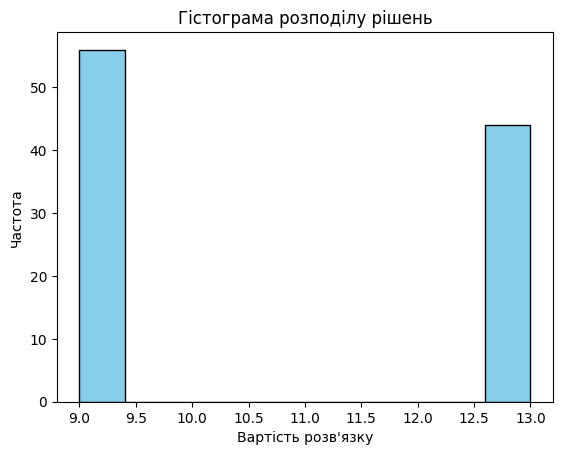

/tmp/ipykernel_976244/2586366870.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


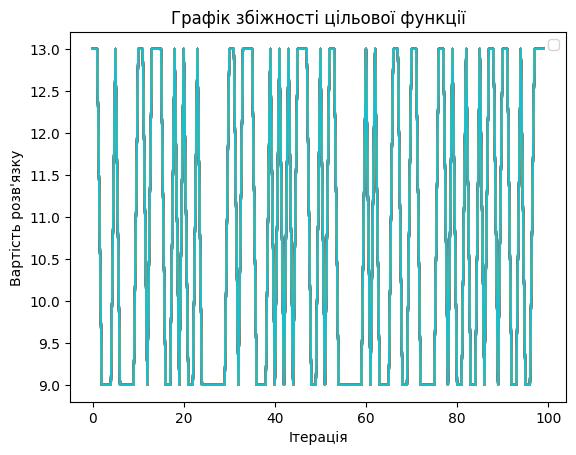

In [153]:
multi_start_solver = MultiStartHillClimbingSolver(solver)
multi_start_solver.multi_start_hill_climbing()

multi_start_solver.show_statistic()
multi_start_solver.hist_plot()
multi_start_solver.objective_function_convergence_plot()